# Language Modeling

In [ ]:
# !pip install torchtext==0.17.2
# !pip install numpy==1.26.4

In [ ]:
%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%capture

In [ ]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

## Tokenization

In [ ]:
from nltk.tokenize import word_tokenize

def preprocess_string(s):
    """
    Preprocesses a given string by performing the following steps:

    1. Removes all non-word characters (excluding letters and numbers).
    2. Removes all whitespace characters.
    3. Removes all numeric digits.

    Parameters:
    s (str): The input string to be cleaned.

    Returns:
    str: The processed string with only alphabetic characters, no spaces, and no digits.
    """
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

def preprocess(words):
    """
    Preprocesses a given text by tokenizing it, cleaning individual words, and
    converting them to lowercase while removing empty or punctuation tokens.

    Steps:
    1. Tokenization: Splits the input text into individual word tokens.
    2. Cleaning: Applies `preprocess_string()` to remove non-word characters,
       spaces, and digits from each token.
    3. Normalization: Converts all tokens to lowercase.
    4. Filtering: Removes empty strings and punctuation tokens.

    Parameters:
    words (str): The input text to be tokenized and preprocessed.

    Returns:
    list: A list of cleaned, lowercase tokens.
    """
    tokens=word_tokenize(words)
    tokens=[preprocess_string(w)   for w in tokens]
    return [w.lower()  for w in tokens if len(w)!=0 or not(w in string.punctuation) ]

tokens=preprocess(song)
tokens[0:10]

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

In [ ]:
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

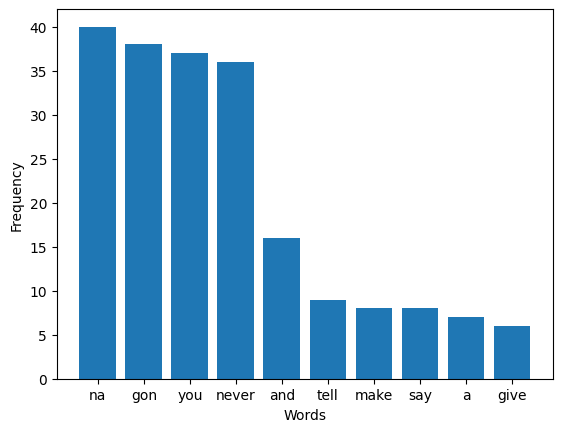

In [ ]:
sorted_dict = dict(sorted(fdist.items(), key=lambda item: item[1], reverse=True))

plt.bar(list(sorted_dict.keys())[0:10],list(sorted_dict.values())[0:10])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

## Indexing

In [ ]:
tokenizer = get_tokenizer("basic_english")
def tokenizetext(song):
    """
    Tokenizes the input text (song) and builds a vocabulary from the tokens.

    Steps:
    1. Tokenization: The function splits the input text into words and applies
       a tokenizer function to each word.
    2. Vocabulary Building: Constructs a vocabulary from the tokenized words,
       including a special "<unk>" token to handle out-of-vocabulary words.
    3. Default Indexing: Sets the default index for unknown words, ensuring
       that any unseen tokens are mapped to "<unk>".

    Parameters:
    song (str): The input text (song lyrics) to be tokenized and processed.

    Returns:
    vocab (Vocab): A vocabulary object mapping tokens to their corresponding indices.
    """
    tokenized_song = map(tokenizer, song.split())
    vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])
    return vocab

vocab=tokenizetext(song)
vocab(tokens[0:10]), tokens[0:10]

([21, 58, 70, 74, 25, 69, 2, 20, 31, 72],
 ['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules'])

## Batch function

In [ ]:
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONTEXT_SIZE = 3
BATCH_SIZE = 10
EMBEDDING_DIM = 10

def collate_batch(batch):
    """
    Processes a batch of text data into input (context) and output (target) tensors
    for training a language model.

    The function extracts:
    - `context`: A list of word indices representing the context words for each target word.
    - `target`: A list of word indices representing the target word to predict.

    Parameters:
    batch (list): A list of tokenized words (strings).

    Returns:
    tuple: Two PyTorch tensors: (context_tensor, target_tensor)
           - context_tensor: Tensor of shape (batch_size - CONTEXT_SIZE, CONTEXT_SIZE),
             containing the word indices of context words.
           - target_tensor: Tensor of shape (batch_size - CONTEXT_SIZE,),
             containing the word indices of target words.
    """
    batch_size = len(batch)
    context, target = [], []
    for i in range(CONTEXT_SIZE, batch_size):
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i - j - 1] for j in range(CONTEXT_SIZE)]))

    return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)

Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad=tokens+tokens[0:Padding]

dataloader = DataLoader(tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

## Multi-class neural network

In [ ]:
class NGramLanguageModeler(nn.Module):
    """
    A neural network-based n-gram language model that predicts the next word
    given a sequence of context words.

    This model consists of:
    - An embedding layer that converts word indices into dense vector representations.
    - A fully connected hidden layer with ReLU activation.
    - An output layer that predicts the probability distribution over the vocabulary.

    Parameters:
    vocab_size (int): The number of unique words in the vocabulary.
    embedding_dim (int): The size of the word embeddings (vector representation of words).
    context_size (int): The number of previous words used as context to predict the next word.
    """
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        """
        Forward pass of the model.

        Parameters:
        inputs (Tensor): A tensor of shape (batch_size, context_size) containing word indices.

        Returns:
        Tensor: A tensor of shape (batch_size, vocab_size) representing predicted probabilities for the next word.
        """
        embeds = self.embeddings(inputs)
        embeds = torch.reshape(embeds, (-1, self.context_size * self.embedding_dim))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out

model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

## Write a Song

In [ ]:
def write_song(model, my_song, number_of_words=100):
    """
    Generates text using a trained n-gram language model.

    Given an initial text (`my_song`), the function generates additional words by
    predicting the next word iteratively based on the trained model.

    Parameters:
    model (nn.Module): The trained n-gram language model.
    my_song (str): The initial seed text to start generating words.
    number_of_words (int): The number of words to generate (default: 100).

    Returns:
    str: The generated song lyrics as a string.
    """
    index_to_token = vocab.get_itos()
    for i in range(number_of_words):
        with torch.no_grad():
            context = torch.tensor(vocab([tokens[i - j - 1] for j in range(CONTEXT_SIZE)])).to(device)
            word_idx = torch.argmax(model(context))
            my_song += " " + index_to_token[word_idx.detach().item()]
    return my_song

def pickrandomline(song):
    """
    Selects a random line from the given song text.

    This function splits the song into separate lines and randomly picks one of them.

    Parameters:
    song (str): The song lyrics as a multi-line string.

    Returns:
    str: A randomly selected line from the song.
    """
    lines = song.split("\n")
    selected_line = random.choice(lines).strip()
    return selected_line

In [ ]:
def train(dataloader, model,song,number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """
    MY_LOSS = []
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0
        my_song = ""
        for context, target in dataloader:
            model.zero_grad()
            predicted = model(context)
            loss = criterion(predicted, target.reshape(-1))
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        if epoch % show == 0:
            selected_line=pickrandomline(song)
            my_song += write_song(model, selected_line)
            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))

    return MY_LOSS

In [ ]:
my_loss_list=[]
CONTEXT_SIZE = 2

model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

my_loss=train(dataloader,model_2,song)

save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

  6%|▌         | 6/100 [00:00<00:03, 29.06it/s]

Generated Song:


Dont tell me youre too blind to see <unk> were <unk> <unk> <unk> <unk> you <unk> we <unk> <unk> <unk> <unk> <unk> <unk> <unk> dont <unk> <unk> <unk> dont <unk> <unk> <unk> too full <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> you <unk> you <unk> you <unk> <unk> you <unk> <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> <unk> you <unk> know <unk> <unk> <unk> you <unk> <unk> <unk> <unk> <unk> <unk> <unk> you <unk> we <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> you from <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> <unk> <unk>


 14%|█▍        | 14/100 [00:00<00:03, 28.54it/s]

Generated Song:


Never gonna give you up never never <unk> you <unk> <unk> you <unk> you <unk> never <unk> you <unk> <unk> never never <unk> never never you <unk> never never you and <unk> <unk> never <unk> <unk> <unk> <unk> tell you never you <unk> you <unk> tell you never never <unk> <unk> tell you never <unk> <unk> <unk> tell you never never <unk> <unk> tell you and <unk> you never <unk> <unk> tell you never you <unk> <unk> tell you never <unk> <unk> tell you never and <unk> you never <unk> never <unk> <unk> <unk> <unk> <unk> never you you <unk> never <unk> <unk> you <unk>


 27%|██▋       | 27/100 [00:00<00:02, 29.84it/s]

Generated Song:


Weve known each other for so long never never <unk> never and <unk> you and never never never <unk> you <unk> <unk> never and never never and you <unk> never never you and <unk> <unk> never <unk> <unk> <unk> <unk> tell you never you <unk> you <unk> tell you never never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you never never <unk> <unk> tell goodbye never <unk> <unk> tell you and and <unk> you never <unk> never <unk> never <unk> never and never never you <unk> never <unk> <unk> you <unk>


 36%|███▌      | 36/100 [00:01<00:02, 27.00it/s]

Generated Song:


Never gonna let you down never never <unk> never and <unk> you and never and never and you <unk> <unk> never and <unk> never and you <unk> never never you and <unk> <unk> never <unk> <unk> <unk> <unk> tell you down you <unk> you <unk> tell you never never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you never never <unk> <unk> tell goodbye never <unk> <unk> tell you and and hurt you never <unk> never <unk> never <unk> never and never been you but never <unk> <unk> you <unk>


 46%|████▌     | 46/100 [00:01<00:01, 28.77it/s]

Generated Song:


Never gonna say goodbye never never know know and <unk> you down never game never and you <unk> <unk> feeling and know never and you <unk> never never you and <unk> <unk> never <unk> <unk> <unk> <unk> tell you how im feeling you <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known never other <unk> <unk> never and never been aching but never <unk> shy never <unk>


 56%|█████▌    | 56/100 [00:01<00:01, 29.19it/s]

Generated Song:


Never gonna give you up never never no know to <unk> you down never game never were you <unk> <unk> feeling and know never and you <unk> never never im and hurt <unk> youre <unk> <unk> <unk> <unk> tell you how im feeling you <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known each other for <unk> and and never been aching but never <unk> shy to <unk>


 66%|██████▌   | 66/100 [00:02<00:01, 29.26it/s]

Generated Song:


Never gonna make you cry never never no strangers to <unk> you down never game never were you i <unk> <unk> and know never thinking know been never never im and hurt <unk> youre <unk> <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known each other for <unk> and and never been aching but youre <unk> shy to <unk>


 77%|███████▋  | 77/100 [00:02<00:00, 30.56it/s]

Generated Song:


Never gonna run around and desert you never never no strangers to <unk> you down never game never were you i <unk> <unk> and know im thinking know been never never im and any <unk> youre i <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known each other for <unk> and and know been aching but youre too shy to <unk>


 84%|████████▍ | 84/100 [00:02<00:00, 29.46it/s]

Generated Song:


Inside we both know whats been going on never never no strangers to <unk> you know never game never were you i <unk> <unk> and know im thinking know been never never this and any other youre i <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known each other for <unk> too and know been aching but youre too shy to <unk>


 96%|█████████▌| 96/100 [00:03<00:00, 31.30it/s]

Generated Song:


Never gonna run around and desert you never never no strangers to love you know the game never were you i <unk> full and know im thinking know been never never this from any other youre i <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you how and hurt you never known each other for <unk> long i know been aching but youre too shy to <unk>


100%|██████████| 100/100 [00:03<00:00, 29.36it/s]


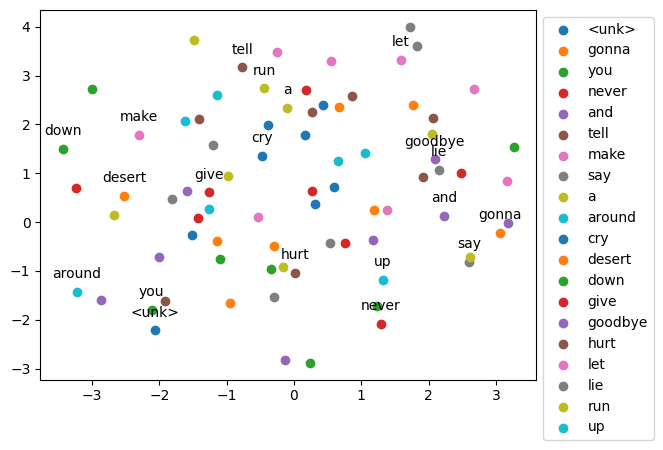

In [ ]:
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)
index_to_token = vocab.get_itos()

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4,song)

save_path = '4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

  4%|▍         | 4/100 [00:00<00:03, 31.41it/s]

Generated Song:


You know the rules and so do I never <unk> <unk> never <unk> <unk> <unk> never never <unk> so <unk> never <unk> <unk> never never <unk> never <unk> <unk> <unk> <unk> never <unk> <unk> never never never <unk> <unk> <unk> <unk> <unk> <unk> <unk> you never never <unk> <unk> <unk> never never <unk> <unk> <unk> <unk> never never <unk> <unk> <unk> never never never <unk> <unk> <unk> never <unk> <unk> <unk> never <unk> <unk> <unk> <unk> never never <unk> <unk> <unk> never never <unk> <unk> <unk> never <unk> <unk> <unk> <unk> never <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> never <unk> <unk> <unk> never


 16%|█▌        | 16/100 [00:00<00:02, 31.44it/s]

Generated Song:


Never gonna make you cry never <unk> <unk> never <unk> never <unk> never never <unk> <unk> <unk> <unk> <unk> <unk> you <unk> <unk> never never <unk> <unk> never <unk> <unk> <unk> never never <unk> <unk> <unk> <unk> <unk> <unk> you never never never never <unk> <unk> you never never <unk> <unk> you you never never <unk> <unk> let you never never <unk> <unk> you you never <unk> you never <unk> <unk> make you never never <unk> <unk> you you never <unk> <unk> tell you never <unk> <unk> you never <unk> <unk> <unk> never <unk> <unk> <unk> <unk> you <unk> <unk> never never <unk> <unk> never


 24%|██▍       | 24/100 [00:00<00:02, 31.79it/s]

Generated Song:


Never gonna make you cry never <unk> <unk> never <unk> never <unk> never never <unk> <unk> you you <unk> <unk> goodbye you <unk> never never <unk> <unk> never <unk> <unk> make never never <unk> <unk> <unk> <unk> <unk> <unk> you down never feeling never <unk> <unk> you never never <unk> <unk> give you never never <unk> <unk> let you down never <unk> <unk> give you never <unk> you never <unk> <unk> make you never never <unk> <unk> say goodbye never <unk> <unk> tell you down <unk> say you never <unk> <unk> <unk> for <unk> <unk> <unk> <unk> you <unk> but never too you <unk> never


 36%|███▌      | 36/100 [00:01<00:02, 30.88it/s]

Generated Song:


Never gonna let you down never im <unk> tell to never you never never <unk> <unk> you you never <unk> goodbye you tell never never <unk> <unk> never known <unk> make never never <unk> <unk> <unk> you <unk> tell you down im feeling never <unk> <unk> you never never <unk> <unk> give you never never <unk> <unk> let you down never <unk> <unk> give you never <unk> you never <unk> <unk> make you never never <unk> <unk> say goodbye never <unk> <unk> tell you down <unk> say you never <unk> <unk> other for but <unk> <unk> <unk> you <unk> but youre too shy to say


 44%|████▍     | 44/100 [00:01<00:01, 30.71it/s]

Generated Song:


Never gonna tell a lie and hurt you never known <unk> strangers to never you know never <unk> <unk> were you never a say you tell im feeling <unk> <unk> never known <unk> make never other <unk> i <unk> we <unk> tell you down im feeling other <unk> <unk> you down never <unk> <unk> give you never never <unk> <unk> let you down never <unk> <unk> give you never <unk> you never <unk> <unk> make you down never <unk> <unk> say goodbye never <unk> <unk> tell you how never let you never known each other for but whats <unk> <unk> been <unk> but youre too shy to say


 56%|█████▌    | 56/100 [00:01<00:01, 30.97it/s]

Generated Song:


We are no strangers to love never known <unk> strangers to love you know the rules other were you never a say you tell im feeling <unk> <unk> say known <unk> make any other guy i <unk> we <unk> tell you down im feeling <unk> <unk> <unk> you cry never <unk> <unk> give you never never <unk> <unk> let you down never <unk> <unk> give you never <unk> you never <unk> <unk> make you cry never <unk> <unk> say goodbye never <unk> <unk> tell you how never let you never known each other for but whats been going been <unk> but youre too shy to say


 64%|██████▍   | 64/100 [00:02<00:01, 30.63it/s]

Generated Song:


Never gonna give you up never known <unk> strangers to love you know the rules other were you never a say you tell im feeling <unk> <unk> we known this from any other guy i let we <unk> tell you how im feeling <unk> <unk> <unk> you cry never <unk> <unk> give you never never <unk> <unk> let you down never <unk> <unk> give you never how you never <unk> <unk> make you cry never <unk> <unk> say goodbye never <unk> <unk> tell you lie never let you never known each other for so long been going been aching but youre too shy to say


 71%|███████   | 71/100 [00:02<00:01, 24.10it/s]

Generated Song:


Never gonna tell a lie and hurt you never are no strangers to love you know the rules <unk> were you never a full commitments what im thinking <unk> <unk> we known this from any other guy i let we <unk> tell you how im feeling <unk> <unk> <unk> you cry never <unk> <unk> give you up never <unk> <unk> let you down never <unk> <unk> give you never how you never <unk> <unk> make you cry never <unk> <unk> say goodbye never <unk> <unk> tell you lie never let you never known each other for so long been know been aching but youre too shy to say


 85%|████████▌ | 85/100 [00:04<00:01, 10.92it/s]

Generated Song:


Never gonna give you up never are no strangers to love you know the rules <unk> were no never a full commitments what im thinking <unk> <unk> we known this from any other guy i let we <unk> tell you how im feeling <unk> <unk> <unk> you cry never <unk> <unk> give you up never <unk> <unk> let you down never <unk> <unk> give you never how you never <unk> <unk> make you cry never <unk> <unk> say goodbye never <unk> <unk> tell you lie never let you never known each other for so long been know been aching but youre too shy to say


 94%|█████████▍| 94/100 [00:04<00:00, 16.40it/s]

Generated Song:


Weve known each other for so long never are no strangers to love you know the rules <unk> were no never a full commitments what im thinking <unk> <unk> we known this from any other guy i let we <unk> tell you how im feeling <unk> <unk> let you cry never <unk> <unk> give you up never <unk> <unk> let you down never <unk> <unk> give you never how you never <unk> <unk> make you cry never <unk> <unk> say goodbye never <unk> <unk> tell you lie never let you never known each other for so long been know been aching but youre too shy to say


100%|██████████| 100/100 [00:04<00:00, 20.40it/s]


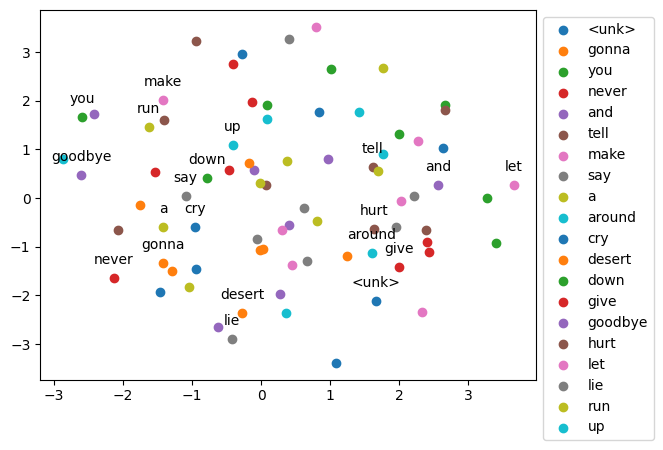

In [ ]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8,song)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

  4%|▍         | 4/100 [00:00<00:03, 30.26it/s]

Generated Song:


Your hearts been aching but youre too shy to say it you tell <unk> <unk> you rules know <unk> for dont for aching to me rules tell me <unk> dont around thinking for you rules on you you for <unk> from i tell see ask i you to <unk> <unk> <unk> <unk> you <unk> <unk> <unk> <unk> know for for <unk> <unk> <unk> commitments you for tell <unk> <unk> give i for for know i <unk> <unk> give you i <unk> <unk> <unk> <unk> i for make <unk> <unk> you <unk> for tell <unk> you know <unk> <unk> <unk> for for <unk> tell tell <unk> ask give <unk> rules you <unk>


 16%|█▌        | 16/100 [00:00<00:02, 33.49it/s]

Generated Song:


Never gonna let you down <unk> <unk> <unk> give to <unk> you <unk> the rules <unk> you around tell <unk> tell make <unk> im thinking <unk> tell you <unk> you you you <unk> <unk> i you tell make you give you im <unk> <unk> <unk> tell you you <unk> <unk> <unk> give you you never <unk> <unk> give you you never <unk> <unk> give you you never <unk> <unk> <unk> <unk> make you you never <unk> <unk> give you you <unk> <unk> tell you <unk> <unk> <unk> tell <unk> <unk> <unk> give for so long <unk> <unk> tell <unk> <unk> give <unk> shy to <unk>


 24%|██▍       | 24/100 [00:00<00:02, 32.36it/s]

Generated Song:


Never gonna tell a lie and hurt you <unk> <unk> <unk> strangers to so long never the rules <unk> you around never i tell to <unk> im thinking <unk> tell tell im me to you im guy i say tell to you give you im feeling <unk> <unk> tell you you never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell you lie never <unk> tell <unk> <unk> <unk> other for so long tell <unk> tell to never tell too shy to say


 36%|███▌      | 36/100 [00:01<00:01, 34.05it/s]

Generated Song:


Never gonna make you cry <unk> <unk> <unk> strangers to so long never the rules <unk> you around never i it to <unk> im thinking <unk> play tell im me strangers for so guy i say long to play give you im feeling <unk> <unk> tell you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> tell <unk> <unk> <unk> other for so long tell <unk> tell to me tell too shy to say


 48%|████▊     | 48/100 [00:01<00:01, 34.14it/s]

Generated Song:


Your hearts been aching but youre too shy to say it <unk> <unk> <unk> strangers to so long never the rules <unk> you around never i it to <unk> im thinking <unk> play tell im me strangers for so guy i say long to play give you im feeling <unk> <unk> tell you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> tell <unk> <unk> feeling other for so long tell <unk> im to me tell too shy to say


 56%|█████▌    | 56/100 [00:01<00:01, 33.88it/s]

Generated Song:


Never gonna tell a lie and hurt you <unk> <unk> <unk> strangers to so long never the rules to you around never i it to <unk> im thinking <unk> play tell im me strangers for so guy i say long to play give you im feeling <unk> <unk> tell you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> tell <unk> <unk> feeling other for so long make <unk> im to me tell too shy to say


 68%|██████▊   | 68/100 [00:02<00:00, 33.57it/s]

Generated Song:


Never gonna make you cry <unk> <unk> <unk> strangers to so long never the rules to you around never i it to <unk> im thinking <unk> play tell im me strangers for so guy i say long to play give you im feeling <unk> <unk> tell you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> tell <unk> <unk> feeling other for so long make <unk> im to me tell too shy to say


 76%|███████▌  | 76/100 [00:02<00:00, 33.52it/s]

Generated Song:


I just wanna tell you how Im feeling <unk> <unk> <unk> strangers to so long never the rules to you around never i it to <unk> im thinking <unk> play tell im me strangers for so guy i say long to play give you im feeling <unk> <unk> tell you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> tell <unk> <unk> feeling other for so long make <unk> im to me tell too shy to say


 84%|████████▍ | 84/100 [00:02<00:00, 32.81it/s]

Generated Song:


Never gonna let you down <unk> <unk> <unk> strangers to so long never the rules to you around never i it to <unk> im thinking <unk> play tell im me strangers for so guy i say long to play give you im feeling <unk> <unk> tell you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> tell <unk> <unk> feeling other for so long make <unk> im to me tell too shy to say


 96%|█████████▌| 96/100 [00:02<00:00, 33.45it/s]

Generated Song:


Never gonna run around and desert you <unk> <unk> <unk> strangers to so long never the rules to you around never i it to <unk> im thinking <unk> play too im me to for so guy i say long to play give you im feeling <unk> <unk> tell you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> <unk> <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> tell <unk> <unk> feeling other for so long make <unk> im to me tell too shy to say


100%|██████████| 100/100 [00:03<00:00, 33.25it/s]


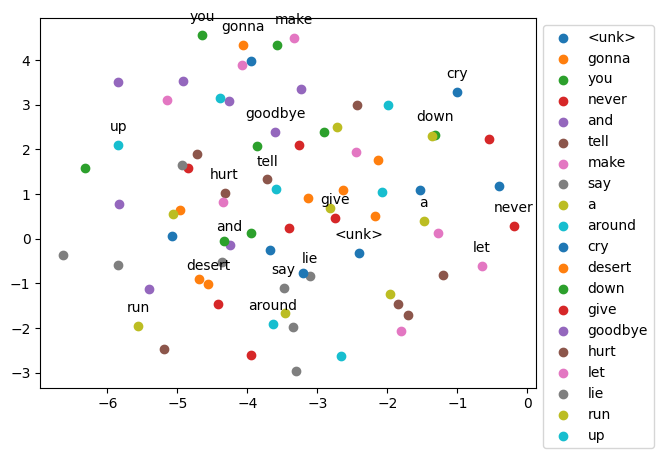

In [ ]:
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

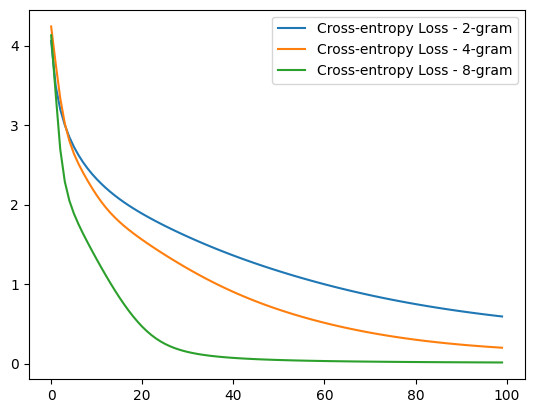

In [ ]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

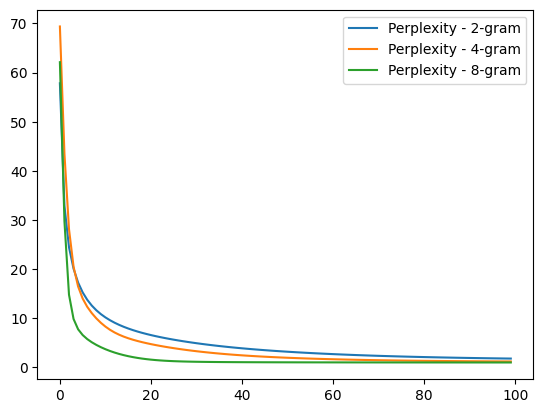

In [ ]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()

## Nursery Ryhmes

In [ ]:
nursery_rhymes = """
Little Miss Muffet
Sat on a tuffet,
Eating her curds and whey;
Along came a spider
Who sat down beside her
And frightened Miss Muffet away.

Twinkle, twinkle, little star,
How I wonder what you are!
Up above the world so high,
Like a diamond in the sky.

Baa, baa, black sheep,
Have you any wool?
Yes sir, yes sir,
Three bags full.

Jack and Jill went up the hill
To fetch a pail of water.
Jack fell down and broke his crown,
And Jill came tumbling after.

Hickory dickory dock,
The mouse ran up the clock.
The clock struck one,
The mouse ran down,
Hickory dickory dock.

Humpty Dumpty sat on a wall,
Humpty Dumpty had a great fall.
All the king's horses and all the king's men
Couldn't put Humpty together again.

Mary had a little lamb,
Its fleece was white as snow;
And everywhere that Mary went,
The lamb was sure to go.

Old MacDonald had a farm,
E-I-E-I-O,
And on his farm he had a cow,
E-I-E-I-O.

Itsy Bitsy Spider climbed up the waterspout.
Down came the rain and washed the spider out.
Out came the sun and dried up all the rain,
And the Itsy Bitsy Spider climbed up the spout again.

The wheels on the bus go round and round,
Round and round,
Round and round.
The wheels on the bus go round and round,
All through the town.

"""

In [ ]:
CONTEXT_SIZE = 3
BATCH_SIZE = 10
EMBEDDING_DIM = 10

tokens = preprocess(nursery_rhymes)
Padding = BATCH_SIZE - len(tokens) % BATCH_SIZE
tokens_pad = tokens + tokens[0:Padding]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

criterion = torch.nn.CrossEntropyLoss()
vocab = tokenizetext(nursery_rhymes)
model3 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
loss_history = train(dataloader, model3, nursery_rhymes)

print(f"Training started with {len(vocab)} words in vocabulary.")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: {scheduler}")

  5%|▌         | 5/100 [00:00<00:02, 41.91it/s]

Generated Song:


All the king's horses and all the king's men water what full ' went full sat went clock water went dumpty s sat went sky went sat went sat sat a water what sat water bitsy put water town what put water went itsy sat clock water water went water full water rain a sat sat went water town who spout full water what clock water what so eating climbed eating lamb up eating ' went tumbling water sheep that clock went who full jill sheep came clock full eating water all who high water clock went clock full went who went full town came went one went went


 17%|█▋        | 17/100 [00:00<00:01, 48.96it/s]

Generated Song:


The wheels on the bus go round and round, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the and the the the the the the the the the the the the the the the the the the the
Generated Song:


 the the the the the the the the the the the the the the the the the and and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the and and the the the the the the the the the the the the the and the the the the the the the the and and the the the the the and the and the the the the the and the the the the the the the the the the the


 39%|███▉      | 39/100 [00:00<00:01, 48.50it/s]

Generated Song:


Itsy Bitsy Spider climbed up the waterspout. the the the the and the the the the the the and the the the the the and and and the the round the the the the the up the the the the and the the the the the the the the the the and the the the the and round the the the the the the the the and the the the and and and the the the the the the the and and and the the the the and the and and and the the the and the and and the up the the the the the the


 49%|████▉     | 49/100 [00:01<00:01, 47.99it/s]

Generated Song:


 the the the the and the and the up a the and the the the a the and and the the the round the the the the the up the the the the spider the and up the the the and and the the and the the the the and round up the up the the the the the and the and the and and and the up the the the the the and and and the and the and and the and and jill the the the and and and humpty the ran up the the the the the


 60%|██████    | 60/100 [00:01<00:00, 50.20it/s]

Generated Song:


Along came a spider little the the sat and a bus the up curds the and the the the a the sat down the the up round the the sat the the up star the the the what and the up the the the and up the a and the the the up up round up the up the up the the the and a and the and and jill the up the the the the the and and and the and the and and the and and jill the up the and and farm humpty up ran up the the the the the
Generated Song:


Along came a spider little the the sat on a bus the her curds the jill the the the spider the sat down the the up round the the sat the the up star the the the what you are up the the the ran up the a and the the the baa baa all up a up the up the the yes and climbed and s jack and jill the up the the the the the and and all the and the and and the and and jill the up the and dickory farm humpty dumpty ran up the the the clock the


 78%|███████▊  | 78/100 [00:01<00:00, 51.76it/s]

Generated Song:


Up above the world so high, little the the sat on a bus the her curds spider jill the came the spider the sat down a the go round the up sat the the up star the the the what you are up the the rain ran spider down a and the the sky baa baa all up a up the up yes sir yes sir climbed and s jack and jill the up the clock the the the and and all jack and down and and the farm and jill came up after and dickory farm humpty dumpty ran up the clock the clock the
Generated Song:


E-I-E-I-O. little miss the sat on a wall eating her curds spider was the came a spider the sat down a bus go round the muffet sat twinkle the up star the the the what you are up the the world ran spider down a a in the sky baa baa all up a up the up yes sir yes sir climbed and s jack and jill went up the clock the the the pail and water jack fell down and and the farm and jill came tumbling after and dickory farm humpty dumpty ran down the clock the clock the


100%|██████████| 100/100 [00:02<00:00, 49.19it/s]

Generated Song:


Like a diamond in the sky. little miss the sat on a wall eating her curds spider was the came a spider the sat down beside bus go round the muffet away twinkle twinkle up star the the the what you are up above the world ran spider down a a in the sky baa baa all up a up the up yes sir yes sir climbed and s jack and jill went up the hill the the the pail and water jack fell down and and the farm and jill came tumbling after and dickory farm humpty dumpty ran down the clock the clock the
Training started with 127 words in vocabulary.
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Learning rate scheduler: <torch.optim.lr_scheduler.StepLR object at 0x78ca17b8e790>


In [ ]:
selected_line = pickrandomline(nursery_rhymes)
generated_rhyme = write_song(model3, selected_line)
print(generated_rhyme)

Jack and Jill went up the hill little miss the sat on a wall eating her curds spider was the came a spider who sat down beside bus go round miss muffet away twinkle twinkle up star a the the what you are up above the world ran spider down a diamond in the sky baa baa all up a you any up yes sir yes sir climbed and climbed jack and jill went up the hill the the the pail and water jack fell down and and the farm and jill came tumbling after and dickory farm humpty dumpty ran down the clock the clock the
